# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
#%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import scipy.special

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [2]:
wine = pd.read_csv(
    'data/monthly-australian-wine-sales.csv', sep=',',
    index_col=['month'], parse_dates=['month'], dayfirst=True)
wine.sales = wine.sales * 1000
wine.head()

,sales
month,
1980-01-01,15136000
1980-02-01,16733000
1980-03-01,20016000
1980-04-01,17708000
1980-05-01,18019000


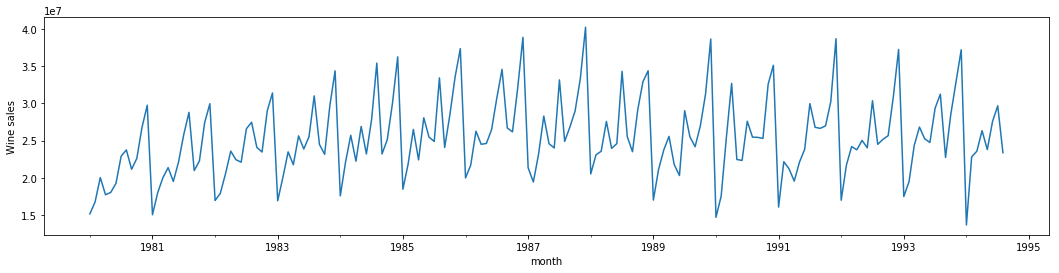

In [3]:
wine.sales.plot(figure=plt.figure(figsize=(18,4)))
plt.ylabel('Wine sales');

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.051161


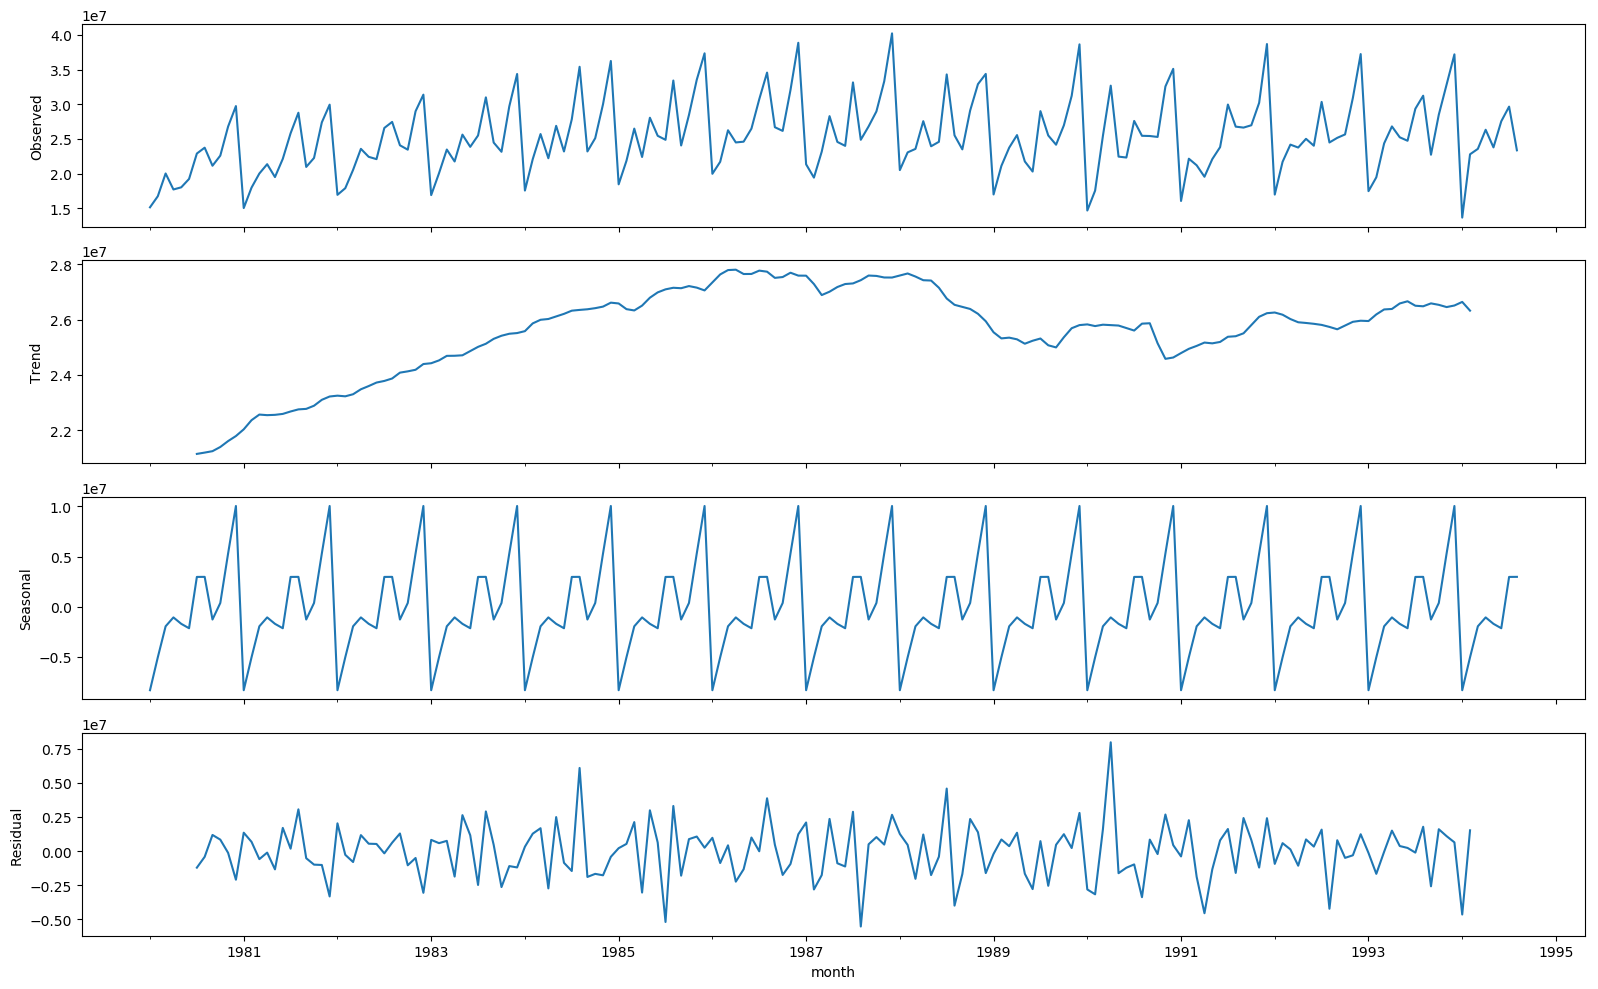

In [23]:
with plt.rc_context(rc={'figure.figsize': (16,10), 'figure.dpi': 100}):
    sm.tsa.seasonal_decompose(wine.sales).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


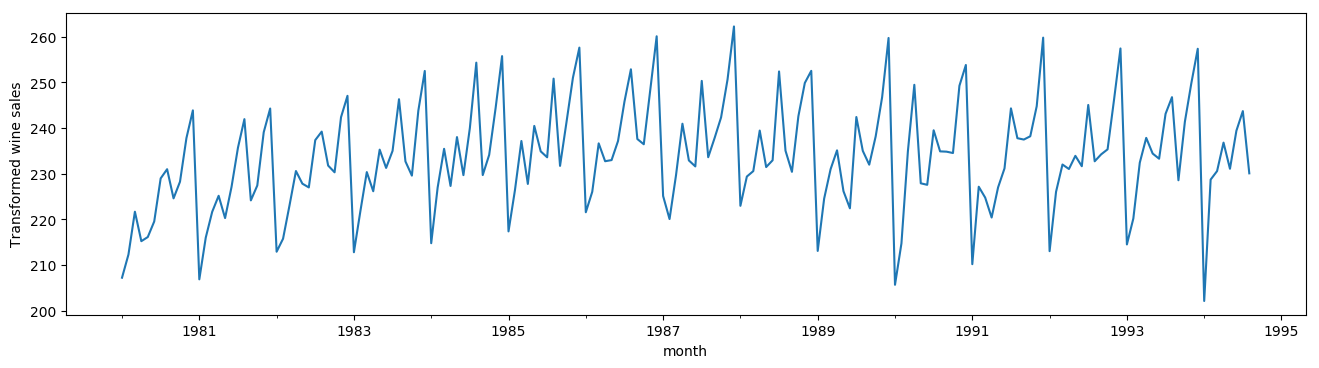

In [28]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
wine.sales_box.plot(figure=plt.figure(figsize=(16, 4), dpi=100))
plt.ylabel('Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.128317


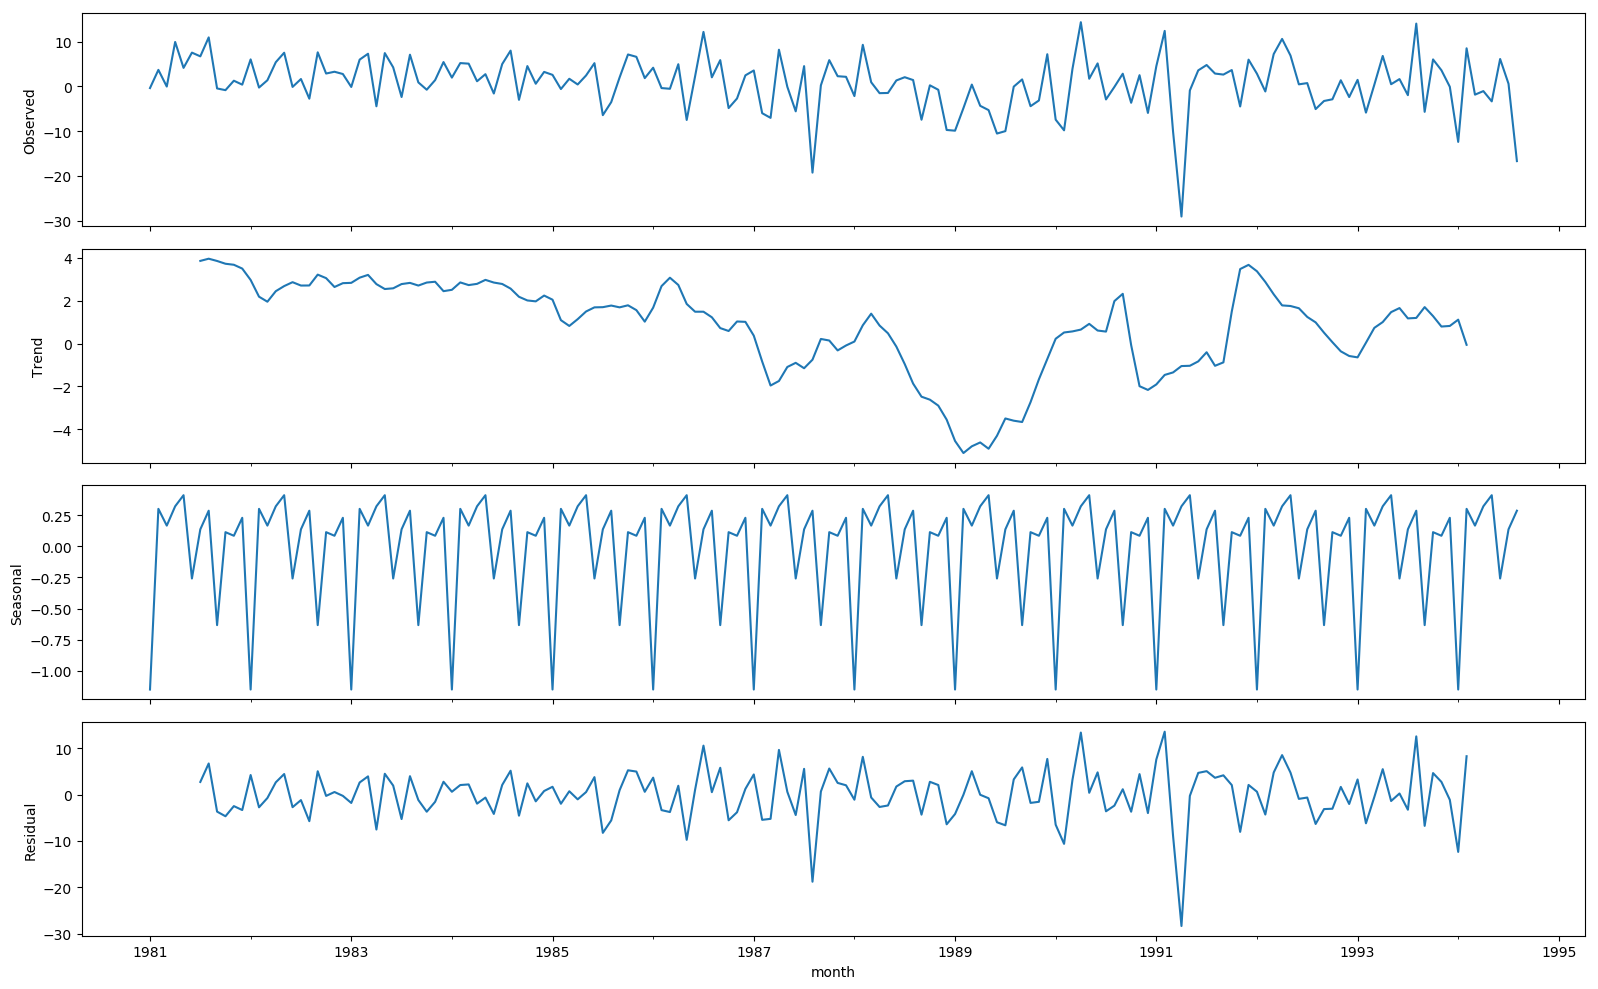

In [29]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
with plt.rc_context({'figure.figsize': (16, 10), 'figure.dpi': 100}):
    sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


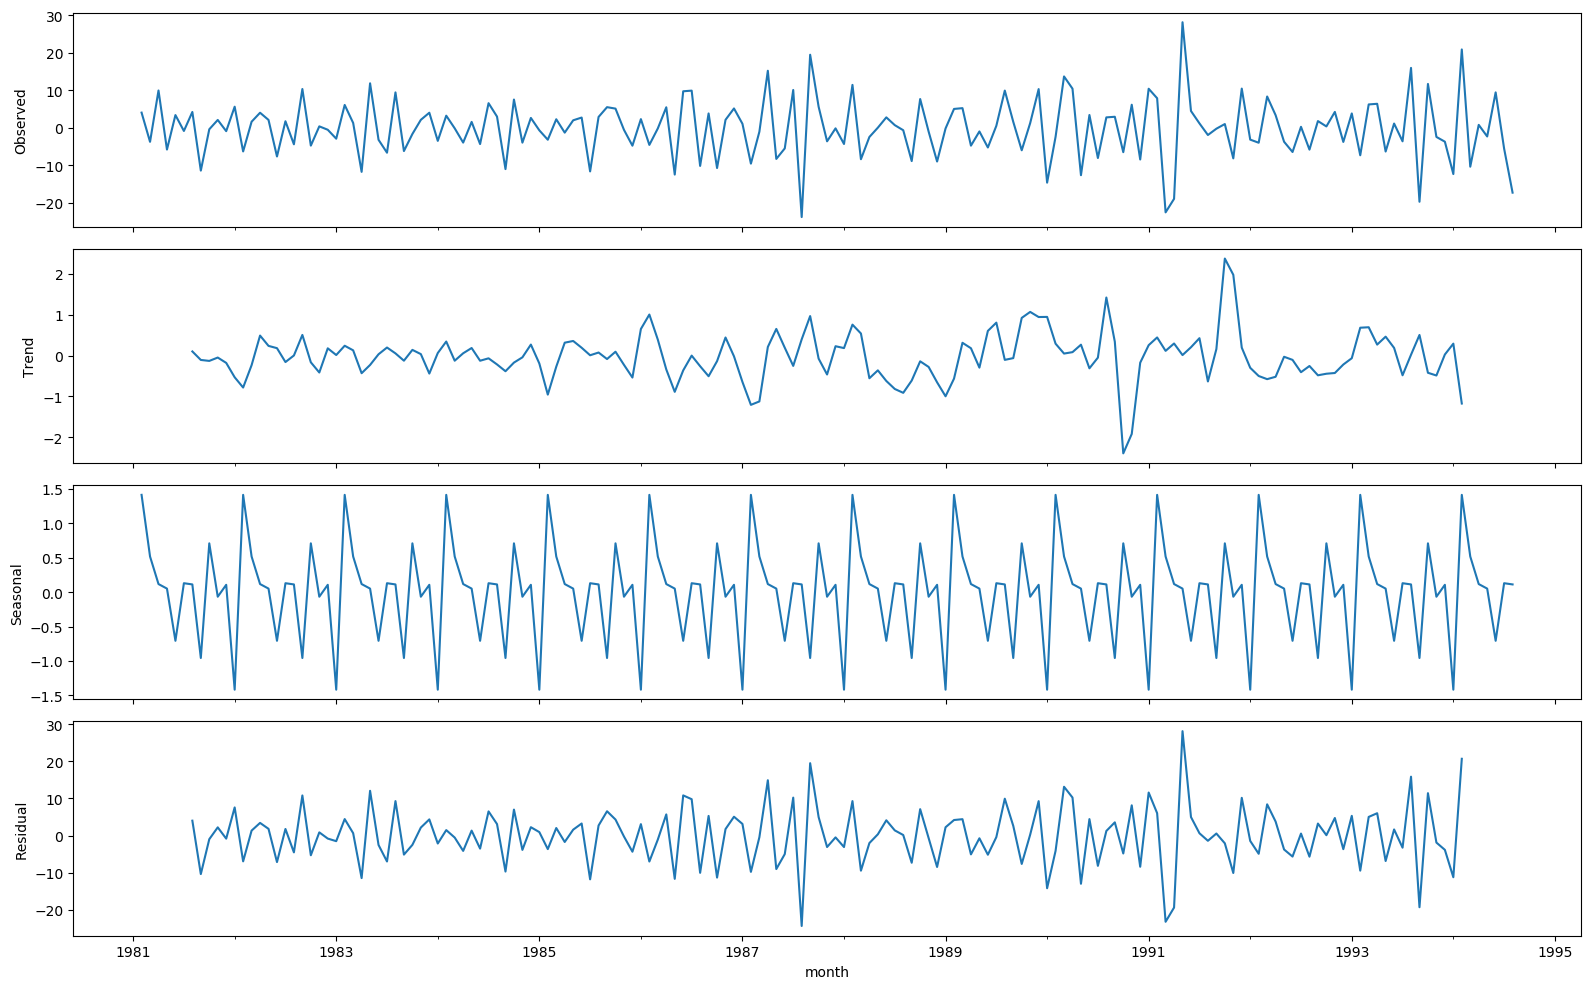

In [31]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
with plt.rc_context(rc={'figure.figsize': (16, 10), 'figure.dpi': 100}):
    sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

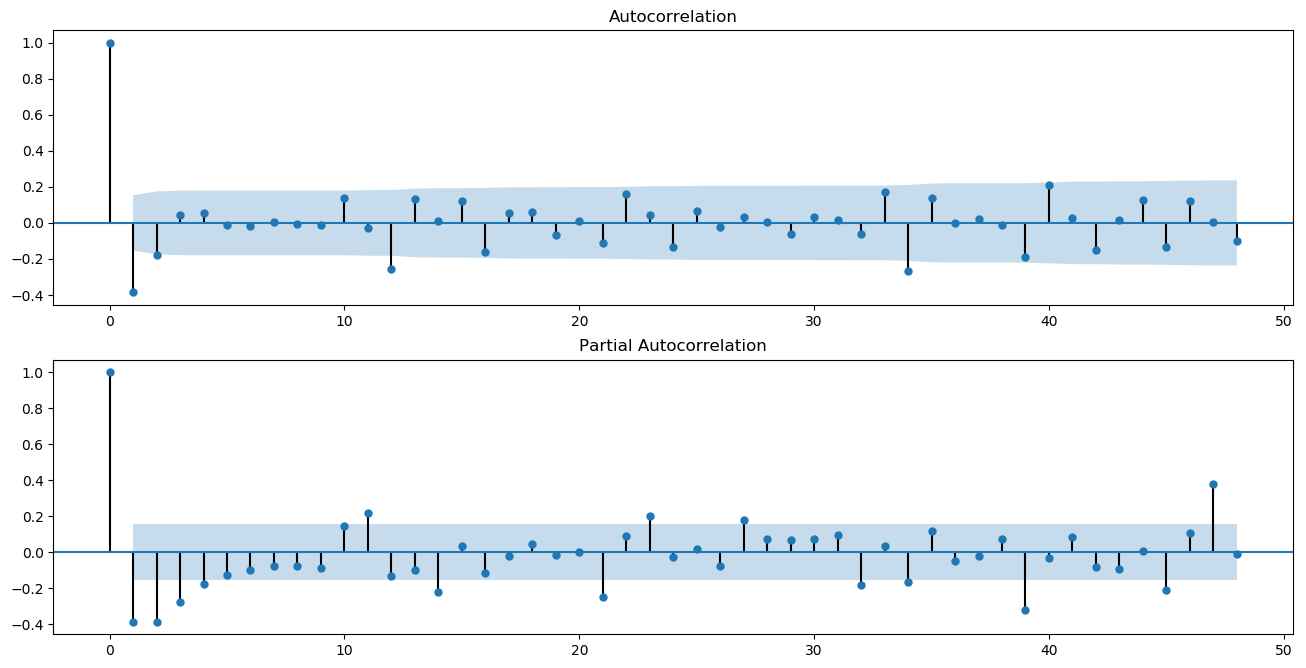

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(16,8), dpi=100)

sm.graphics.tsa.plot_acf(
    wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax[0])

sm.graphics.tsa.plot_pacf(
    wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax[1])

plt.show()

Начальные приближения: $ Q=1, \quad q=2,\quad P=1,\quad p=4$ 

In [62]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [63]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [67]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах 
    # параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            wine.sales_box,
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и 
    # переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
CPU times: user 34.6 s, sys: 970 ms, total: 35.6 s
Wall time: 11.5 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [174]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -498.012
Date:                            Thu, 25 Oct 2018   AIC                           1006.024
Time:                                    11:40:50   BIC                           1021.493
Sample:                                01-01-1980   HQIC                          1012.305
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9103      0.053     17.036      0.000       0.806       1.015
ma.L1         -1.9305      0.035    -55.267      0.000      -1.999      -1.862
ma.L2          0.9503      0.033     28.733      0.000       0.885       1.015
ma.S.L12      -0.7172      0.053    -13.432      0.000      -0.822      -0.613
sigma2        24.6917      1.913     12.909      0.000      20.943      28.441
===================================================================================
Ljung-Box (Q):                       43.11   Jarque-Bera (JB):                40.47
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
best_model.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 1,
 'ma': 2,
 'seasonal_ar': 0,
 'seasonal_ma': 12,
 'reduced_ar': 1,
 'reduced_ma': 14,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [139]:
result_table = pd.DataFrame(results)
result_table.columns = ['p, q, P, Q', 'aic']
s = result_table.sort_values(by = 'aic', ascending=True).head()

In [141]:
print(s)

      p, q, P, Q          aic
17  (1, 2, 0, 1)  1006.024479
25  (2, 1, 0, 1)  1007.801553
27  (2, 1, 1, 1)  1008.786538
29  (2, 2, 0, 1)  1009.284267
37  (3, 1, 0, 1)  1009.723537


Лучшая модель:

In [69]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -498.012
Date:                            Thu, 25 Oct 2018   AIC                           1006.024
Time:                                    00:47:16   BIC                           1021.493
Sample:                                01-01-1980   HQIC                          1012.305
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9103      0.053     17.036      0.000       0.806       1.015
ma.L1         -1.9305      0.035   

Её остатки:

Критерий Стьюдента: p=0.384957
Критерий Дики-Фуллера: p=0.000000


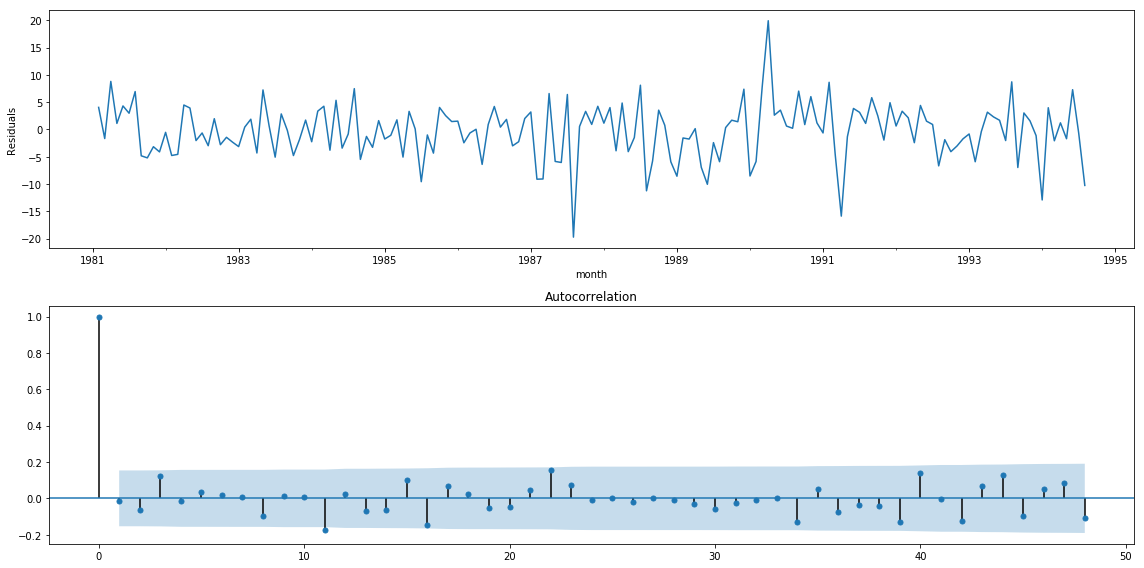

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

best_model.resid[13:].plot(ax=ax[0])
ax[0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax[1])
fig.tight_layout();

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [81]:
import numpy as np

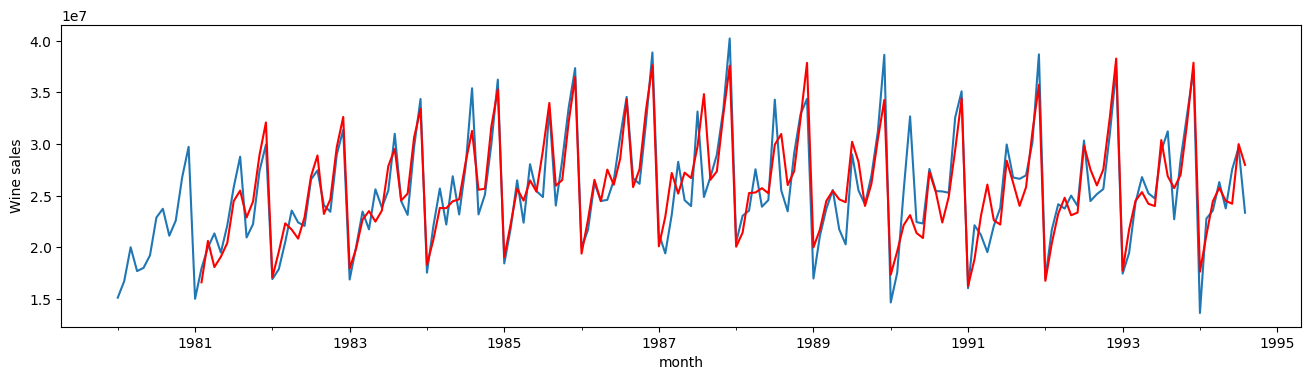

In [90]:
wine['model'] = scipy.special.inv_boxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(16,4), dpi=100)
wine.sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
plt.show()

### Прогноз

In [98]:
import datetime
from dateutil.relativedelta import *

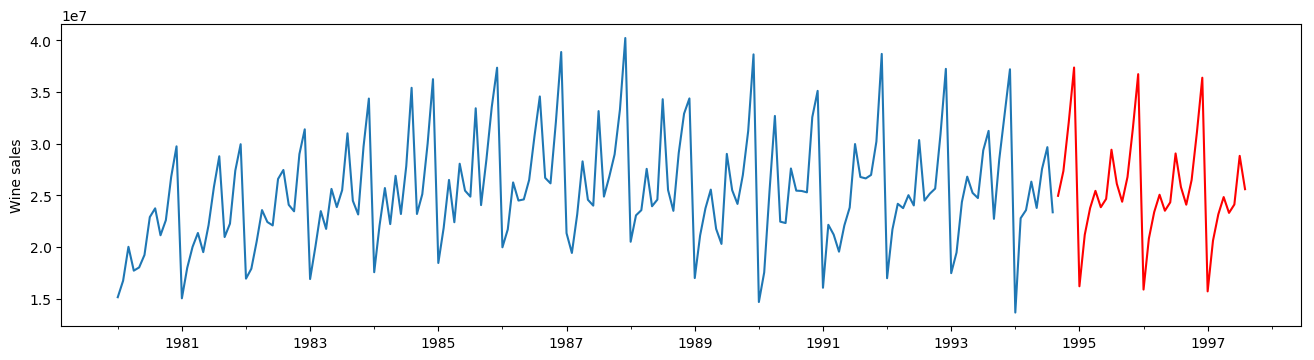

In [120]:
wine2 = wine[['sales']]
date_list = [
    datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + 
    relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = scipy.special.inv_boxcox(
    best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize=(16,4), dpi=100)
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
plt.show()

In [122]:
from itertools import product as prod

In [191]:
import importlib
importlib.reload(sarimax)

<module 'sarimax' from '/Users/artem/pyprojects/mldaspec/course5/notebooks/sarimax.py'>

In [192]:
model = sarimax.SeriesModel(wine.sales_box)

In [193]:
model.fit_sarimax()

In [194]:
model.results_table

,"p, q, P, Q",AIC
1,"(1, 0, 0, 0)",1459.843116
0,"(0, 0, 0, 0)",2421.899623


In [195]:
model

TypeError: __repr__ returned non-string (type Summary)

In [196]:
str(model.best_model.summary())

'                           Statespace Model Results                           \n==============================================================================\nDep. Variable:              sales_box   No. Observations:                  176\nModel:               SARIMAX(1, 0, 0)   Log Likelihood                -727.922\nDate:                Thu, 25 Oct 2018   AIC                           1459.843\nTime:                        11:43:34   BIC                           1466.184\nSample:                    01-01-1980   HQIC                          1462.415\n                         - 08-01-1994                                         \nCovariance Type:                  opg                                         \n==============================================================================\n                 coef    std err          z      P>|z|      [0.025      0.975]\n------------------------------------------------------------------------------\nar.L1          0.9978      0.007    140